In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
from string import ascii_lowercase


baseUrl = 'http://mll.stats.pointstreak.com/'

# get list of names and links to every player page in the MLL
playerlinks = list()
playernames = list()
basePlayerUrl = baseUrl + 'playerslist.html?leagueid=323&seasonid=18259&letter='

for letter in ascii_lowercase:
    page = requests.get(basePlayerUrl + letter)
    soup = BeautifulSoup(page.text, 'html.parser')
    for player in soup.find_all('td', class_='searchresults'):
        playerlinks.append(player.find('a').get('href'))
        playernames.append(player.find('a').text[:-6])
        
# format names
formattednames = list()
for name in playernames:
    tup = name.replace(" ", "").split(',')
    tup.reverse()
    inorder = ' '.join(tup)
    formattednames.append(inorder)

In [3]:
positions = list()
games = list()
gbspergame = list()
ctopergame = list()
goalspergame = list()
assistpergame = list()
svpct = list()
fopct = list()


# acquire data for each player by iterating through pages
for link in playerlinks:
    playerpage = requests.get(baseUrl + link)
    playersoup = BeautifulSoup(playerpage.text, 'html.parser')
    
    # determine position
    posres = playersoup.find('strong', text = 'Position:')
    position = posres.parent.text[10:]
    positions.append(position)
    
    playertotals = playersoup.find('td', text = 'TOTALS')
    statscat = playertotals.parent
    stats = statscat.find_all('td')
    gamesplayed = float(stats[1].text)
    games.append(gamesplayed)
    if (gamesplayed == 0):
        if position == 'G': # special case - bad formatting on MLL website
            gbspergame.append(-1)
            gplayertotals = playersoup.find_all('td', text = 'TOTALS')
            if len(gplayertotals) > 2:
                gstatscat = gplayertotals[2].parent
                gstats = gstatscat.find_all('td')
                gsvp = float(gstats[10].text)
                svpct.append(gsvp)
                # add -1 for stats irrelevant to this position
                ctopergame.append(-1)
                goalspergame.append(-1)
                assistpergame.append(-1)
                fopct.append(-1)
            else:
                svpct.append(-1)
                ctopergame.append(-1)
                goalspergame.append(-1)
                assistpergame.append(-1)
                fopct.append(-1)
        else:            
            gbspergame.append(-1)
            svpct.append(-1)
            ctopergame.append(-1)
            goalspergame.append(-1)
            assistpergame.append(-1)
            fopct.append(-1)
    else:
        # based on position, acquire relevant stats
        if (position == 'M') or (position =='A'):
            gbs = float(stats[12].text) # ground balls
            gbspergame.append(gbs / gamesplayed)
            goals = float(stats[2].text) # goals
            goalspergame.append(goals / gamesplayed)
            assists = float(stats[4].text) # assists
            assistpergame.append(assists / gamesplayed)
            # add -1 for stats irrelevant to this position
            ctopergame.append(-1)
            svpct.append(-1)
            fopct.append(-1)
        elif position == 'D':
            gbs = float(stats[12].text) # ground balls
            gbspergame.append(gbs / gamesplayed)
            cto = float(stats[15].text) # caused turn overs
            ctopergame.append(cto / gamesplayed)
            # add -1 for stats irrelevant to this position
            svpct.append(-1)
            goalspergame.append(-1)
            assistpergame.append(-1)
            fopct.append(-1)
        elif position == 'G':
            gbspergame.append(-1) # gbs not listed for goalies
            ctopergame.append(-1)
            goalspergame.append(-1)
            assistpergame.append(-1)
            fopct.append(-1)
            if stats[10].text == '-': # special case where '-' substituted for '0'
                svpct.append(0.0)
            else:
                svp = float(stats[10].text) # save %
                svpct.append(svp)
        elif (position == 'F') or (position == 'FO'):
            gbs = float(stats[12].text) # ground balls
            gbspergame.append(gbs / gamesplayed)
            fo = stats[19]
            fovals = fo.text.split('-')
            svpct.append(-1)
            ctopergame.append(-1)
            goalspergame.append(-1)
            assistpergame.append(-1)
            if float(fovals[1]) == 0:
                fopct.append(-1)
            else:
                fopctval = float(fovals[0]) / float(fovals[1])
                fopct.append(fopctval)
        else: # no player data
            gbspergame.append(-1)
            svpct.append(-1)
            ctopergame.append(-1)
            goalspergame.append(-1)
            assistpergame.append(-1)
            fopct.append(-1)


In [5]:
# get names of all players in PLL (from initial PLL announcement)
pllplayers = list()

pllurl = 'https://www.insidelacrosse.com/article/premier-lacrosse-league-announces-140-plus-player-list/53201'
pllpage = requests.get(pllurl)
pllsoup = BeautifulSoup(pllpage.text, 'html.parser')
plldata = pllsoup.find_all('td')

for i in range(1, len(plldata), 3):
    pllplayers.append(plldata[i].text.replace("\xa0", " "))

In [8]:
import pandas as pd

# create dataframe of all players
dic = {'Name': formattednames, 'Position': positions, 'Games Played': games, 'GBs per Game': gbspergame, 
       'Goals per Game': goalspergame, 'Assists per Game': assistpergame, 'Caused Turn-Overs per Game': ctopergame,
       'Face-Off Percentage': fopct, 'Save Percentage': svpct}
df = pd.DataFrame(data = dic)

inPLL = list()

for row in df['Name']:
    inPLL.append(row in pllplayers) # check if player is in the PLL this year

df['Going to PLL in 2019'] = inPLL

,Name,Position,Games Played,GBs per Game,Goals per Game,Assists per Game,Caused Turn-Overs per Game,Face-Off Percentage,Save Percentage,Going to PLL in 2019
0,Matt Abbott,M,127.0,2.787402,0.818898,0.488189,-1.000000,-1.000000,-1.000,False
1,Brent Adams,M,60.0,1.633333,0.950000,0.300000,-1.000000,-1.000000,-1.000,True
2,Drew Adams,G,122.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.528,True
3,Jack Adams,M,3.0,1.666667,0.000000,0.000000,-1.000000,-1.000000,-1.000,False
4,Max Adler,M,10.0,6.800000,0.100000,0.100000,-1.000000,-1.000000,-1.000,False
5,Dominique Alexander,M,77.0,1.532468,0.090909,0.207792,-1.000000,-1.000000,-1.000,True
6,Niko Amato,G,28.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0.497,False
7,Ryan Ambler,A,16.0,1.000000,1.250000,0.625000,-1.000000,-1.000000,-1.000,True
8,Nick Aponte,A,5.0,1.000000,0.600000,0.800000,-1.000000,-1.000000,-1.000,False
9,Trevor Baptiste,FO,7.0,9.000000,-1.000000,-1.000000,-1.000000,0.554054,-1.000,True


In [16]:
# partition by position
# drop any player with -1 as their relevant stat

offensedf = df.loc[(df['Position'] == 'A') | (df['Position'] == 'M')]
newoffensedf = offensedf.drop(columns=['Position', 'Caused Turn-Overs per Game', 'Face-Off Percentage', 'Save Percentage'])
orowstodrop = newoffensedf[newoffensedf['Goals per Game'] == float(-1)].index
newoffensedf.drop(orowstodrop, inplace=True)

defensedf = df.loc[(df['Position'] == 'D')]
newdefensedf = defensedf.drop(columns=['Position', 'Goals per Game', 'Assists per Game', 'Face-Off Percentage', 'Save Percentage'])
drowstodrop = newdefensedf[newdefensedf['Caused Turn-Overs per Game'] == float(-1)].index
newdefensedf.drop(drowstodrop, inplace=True)

goaliedf = df.loc[(df['Position'] == 'G')]
newgoaliedf = goaliedf.drop(columns=['Position', 'GBs per Game', 'Goals per Game', 'Assists per Game', 'Caused Turn-Overs per Game', 'Face-Off Percentage'])
growstodrop = newgoaliedf[newgoaliedf['Save Percentage'] == float(-1)].index
newgoaliedf.drop(growstodrop, inplace=True)

fodf = df.loc[(df['Position'] == 'F') | (df['Position'] == 'FO')]
newfodf = fodf.drop(columns=['Position', 'Goals per Game', 'Assists per Game', 'Caused Turn-Overs per Game', 'Save Percentage'])
frowstodrop = newfodf[newfodf['Face-Off Percentage'] == float(-1)].index
newfodf.drop(frowstodrop, inplace=True)

,Name,Games Played,GBs per Game,Goals per Game,Assists per Game,Going to PLL in 2019
0,Matt Abbott,127.0,2.787402,0.818898,0.488189,False
1,Brent Adams,60.0,1.633333,0.950000,0.300000,True
3,Jack Adams,3.0,1.666667,0.000000,0.000000,False
4,Max Adler,10.0,6.800000,0.100000,0.100000,False
5,Dominique Alexander,77.0,1.532468,0.090909,0.207792,True


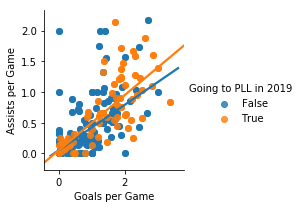

In [23]:
# visualization
import numpy 
import pandas
from  matplotlib import pyplot
import seaborn


ofg = seaborn.FacetGrid(data=newoffensedf, hue='Going to PLL in 2019')
ofg.map(pyplot.scatter, 'Goals per Game', 'Assists per Game')
ofg.map(seaborn.regplot, 'Goals per Game', 'Assists per Game', ci=None, robust=1)
ofg.add_legend()

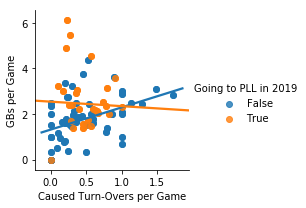

In [28]:
dfg = seaborn.FacetGrid(data=newdefensedf, hue='Going to PLL in 2019')
dfg.map(pyplot.scatter, 'Caused Turn-Overs per Game', 'GBs per Game')
dfg.map(seaborn.regplot, 'Caused Turn-Overs per Game', 'GBs per Game', ci=None, robust=1)
dfg.add_legend()

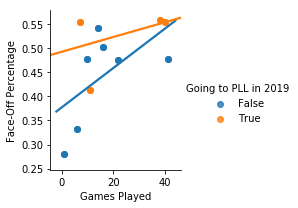

In [29]:
ffg = seaborn.FacetGrid(data=newfodf, hue='Going to PLL in 2019')
ffg.map(pyplot.scatter, 'Games Played', 'Face-Off Percentage')
ffg.map(seaborn.regplot, 'Games Played', 'Face-Off Percentage', ci=None, robust=1)
ffg.add_legend()

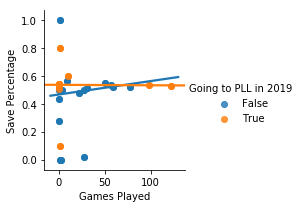

In [30]:
gfg = seaborn.FacetGrid(data=newgoaliedf, hue='Going to PLL in 2019')
gfg.map(pyplot.scatter, 'Games Played', 'Save Percentage')
gfg.map(seaborn.regplot, 'Games Played', 'Save Percentage', ci=None, robust=1)
gfg.add_legend()